In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Periodic Signals & The Lomb-Scargle Periodogram
By AA Miller (2019 Jun ~10)  
Updated by G Hosseinzadeh (2025 May 27)

This notebook discusses the detection of periodic signals in noisy, irregular data (the standard for ground-based astronomical surveys). The discussion below is strongly influenced by "Understanding the Lomb-Scarge Periodogram" ([VanderPlas 2017](http://adsabs.harvard.edu/abs/2017arXiv170309824V)). Beyond that, the original papers by [Lomb (1976)](http://adsabs.harvard.edu/abs/1976Ap%26SS..39..447L) and [Scargle (1982)](http://adsabs.harvard.edu/abs/1982ApJ...263..835S) are also worth a read. Though there are many, many papers on the use of the Lomb-Scargle periodogram, [Graham et al. (2013)](http://adsabs.harvard.edu/abs/2013MNRAS.434.3423G) conducted a systematic analysis of many of the most popular tools used to search for periodic signals on *actual astronomical data* and found that none of the solutions work really well across all use cases!

We'll be using a sinusoidal model throughout this exercise, so write a function that implements the following equation:

$$ y = A\,\sin\left(\frac{2{\pi}x}{P} - \phi\right) + \sigma_y$$

where $A, P, \phi$ are free parameters. It should have the option to Gaussian noise, $\sigma_y$, for each output $y_i$.

Test that it works by generating a noise-free signal with $A = 2$ and $P = \pi$ over a regular grid between 0 and 10. Plot the results.

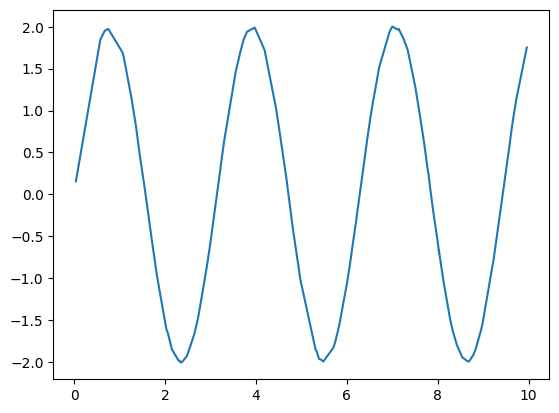

In [2]:
rng = np.random.default_rng()

def sinusoid(x, period=1, amplitude=1, phase=0, noise=0):
    sine_content = (2 * np.pi * x / period) - phase
    signal = amplitude * np.sin(sine_content)
    noise = rng.normal(0, noise, size=len(x)) if noise > 0 else 0
    return signal + noise


x =  np.random.rand(110) * 10
x = np.sort(x)
f = 2*np.pi*x
y = sinusoid(x, amplitude=2, period=np.pi, noise=0.01)
plt.plot(x,y)
plt.show()

## Problem 1) The Lomb-Scargle Periodogram

**Problem 1a**

Write a function, `chi2`, to calculate the $\chi^2$ given $f$, $A_f$, and $\phi$, for observations $y_n$ with uncertainties $\sigma_{y,n}$ taken at times $t_n$.

*Hint* - it may be helpful to access $A_f$, and $\phi$ from a single variable `theta`, where `a = theta[0]` and `phi = theta[1]`

$$\chi^2 (f) = \sum_n \frac{y_n - A(f)sin(2\pi f[t_n - \phi(f)])}{\sigma_n}$$

In [3]:
def chi2(theta, f, t, y, dy):
    """
    Compute chi^2

    Parameters
    ----------
    f: float
        Frequency

    theta: array-like
        [A, phi] - amplitude and phase

    t: array-like
        Time

    y: array-like
        True Model

    dy: array-like
        Uncertainties on y

    Returns
    -------
    chi_squared: float
    """
    
    a, phi = theta

    sine_content = 2 * np.pi * f * (t - phi)
    model = a * np.sin(sine_content)
    chi = (y - model)/dy
    return np.sum(chi**2)

**Problem 1b**

Write a function to minimize the $\chi^2$ given everything but $A_f$ and $\phi_f$.

*Hint* - you may find [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) within the `scipy` package useful.

In [4]:
from scipy.optimize import minimize

def minimize_chi2(f, t, y, dy, theta):
    """
    Minimize chi^2 w.r.t. amplitude and phase at fixed frequency f.

    Returns
    -------
    minimized_chi2
    """
    
    minimized_chi2 = minimize(chi2, x0=theta, args=(f, t, y, dy))
    return minimized_chi2

**Problem 1c**

Write a function, `ls_periodogram`, to calculate the LS periodogram for observations $y$, $\sigma_y$, $t$ over a frequency grid `f_grid`.

In [5]:
def ls_periodogram(t, y, dy, f_grid, theta0=(1.0, 0.0)):
    """
    Compute the Lomb-Scargle periodogram

    Returns
    -------
    psd : array-like
        Lomb-Scargle at each frequency
    """
    psd = np.zeros_like(f_grid)

    # chi_0^2: non-varying reference model
    y_mean = np.average(y, weights=1 / dy**2)
    chi2_0 = np.sum(((y - y_mean) / dy) ** 2)

    # minimize chi^2 for each f_grid
    for f_num, f in enumerate(f_grid):
        result = minimize_chi2(f, t, y, dy, theta0)
        chi2_f = result.fun
        psd[f_num] = (chi2_0 - chi2_f) / 2

    return psd


**Problem 1d**

Generate a periodic signal with 100 observations taken over a time period of 10 days. Use an input period of 5.25, amplitude of 7.4, and variance of the noise = 0.8. To make this more realistic, randomly generate uncertainties from a half-Gaussian with a standard deviation of 0.8. Then compute and plot the periodogram for the simulated data. Do you recover the simulated period?

*Hint* - set the minimum frequency in the grid to $1/T$ where $T$ is the duration of the observations. Set the maximum frequnecy to 10, and use an equally spaced grid with 50 points. 

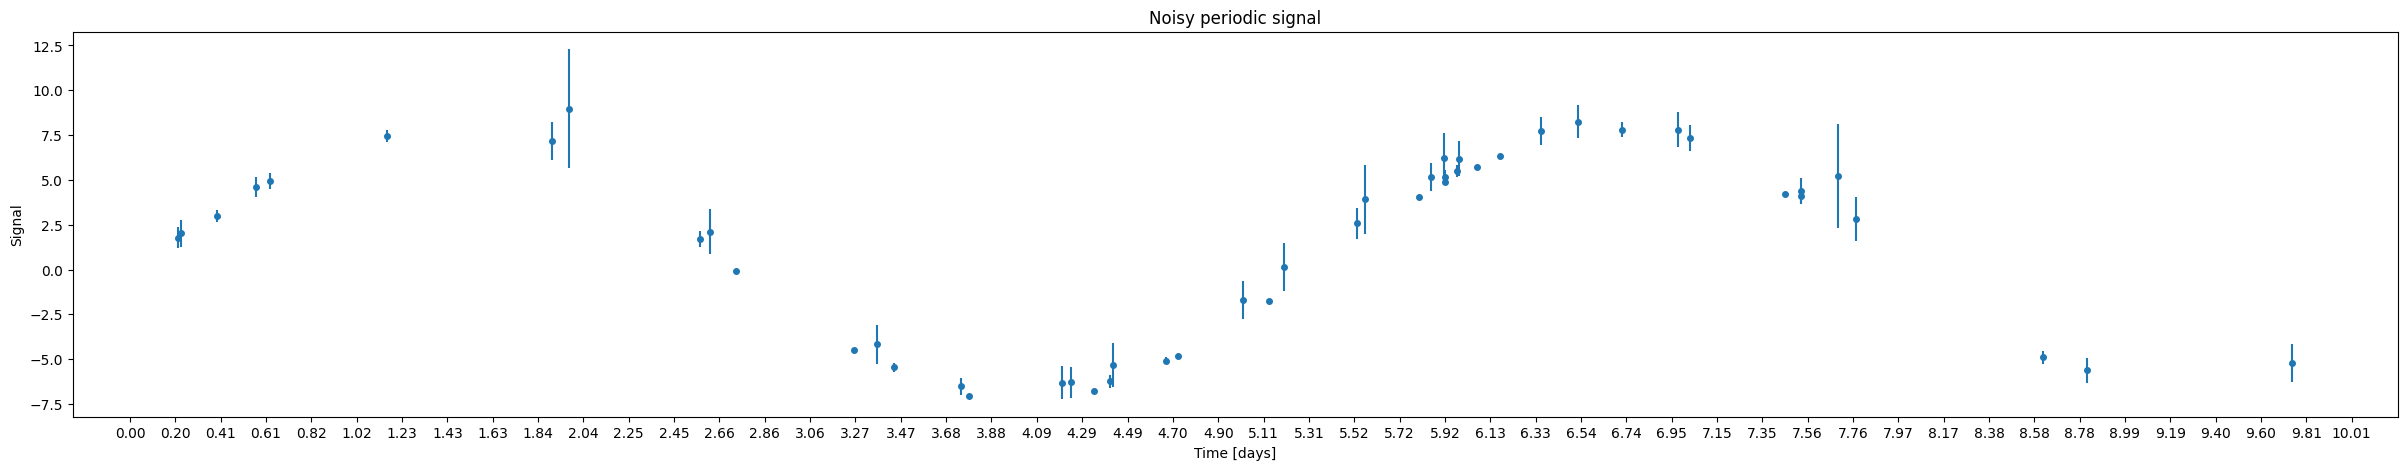

In [6]:
x =  np.sort(np.random.uniform(0,10,50))
y_clean =  sinusoid(x, period=5.25, amplitude=7.4, phase=1/10, noise=0)
dy =  np.abs(np.random.normal(0,0.8,size=len(x))) # half-gaussian uncertainties
y = y_clean + dy

fig, ax = plt.subplots(figsize=(30,5))
ax.errorbar(x, y, yerr=dy, fmt='o', markersize=4)
ax.set_xlabel('Time [days]')
ax.set_ylabel('Signal')
ax.set_title('Noisy periodic signal')
ax.set_xticks(np.linspace(0, 10.01, 50))
plt.show()

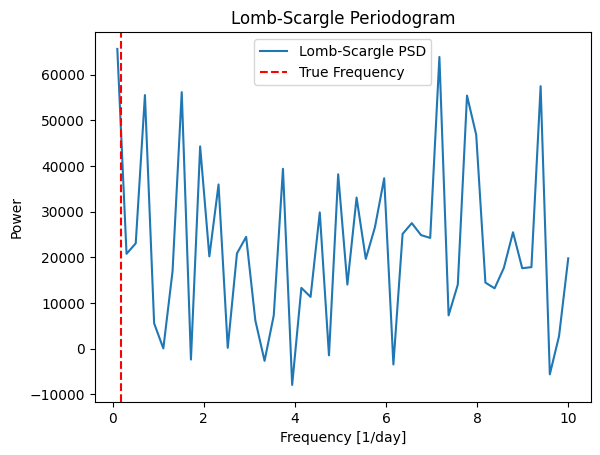

The best fit period is: 9.5233


In [7]:
# set up f_grid for ls_periodogram
f_min = 1 / (max(x) - min(x)) # the smallest fraction possible for minimum f
f_max = 10 
f_grid = np.linspace(f_min, f_max, 50)

psd_ls = ls_periodogram(x, y, dy, f_grid)

# plot the periodogram (I did not get the correct frequency back :(. )
plt.plot(f_grid, psd_ls, label="Lomb-Scargle PSD")
plt.axvline(1/5.25, color='r', linestyle='--', label='True Frequency')
plt.xlabel("Frequency [1/day]")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")
plt.legend()
plt.show()

print("The best fit period is: {:.4f}".format(1. / f_grid[np.argmax(psd_ls)]))


**Problem 1e**

For the same data, include 1000 points in `f_grid` and calculate and plot the periodogram. 

Now do you recover the correct period?

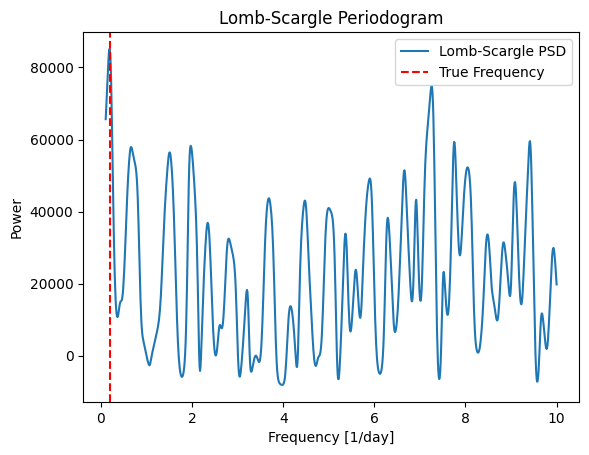

The best fit period is: 5.1507


In [8]:
# set up f_grid for ls_periodogram
f_min = 1 / (max(x) - min(x))  # the smallest fraction possible for minimum f
f_max = 10 
f_grid = np.linspace(f_min, f_max, 1000)

psd_ls = ls_periodogram(x, y, dy, f_grid)

# plot the periodogram (I did not get the correct frequency back :(. )
plt.plot(f_grid, psd_ls, label="Lomb-Scargle PSD")
plt.axvline(1/5.25, color='r', linestyle='--', label='True Frequency')
plt.xlabel("Frequency [1/day]")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")
plt.legend()
plt.show()

print("The best fit period is: {:.4f}".format(1. / f_grid[np.argmax(psd_ls)]))


**Problem 1f**

Plot the phase-folded data at the newly found "best" fit period.

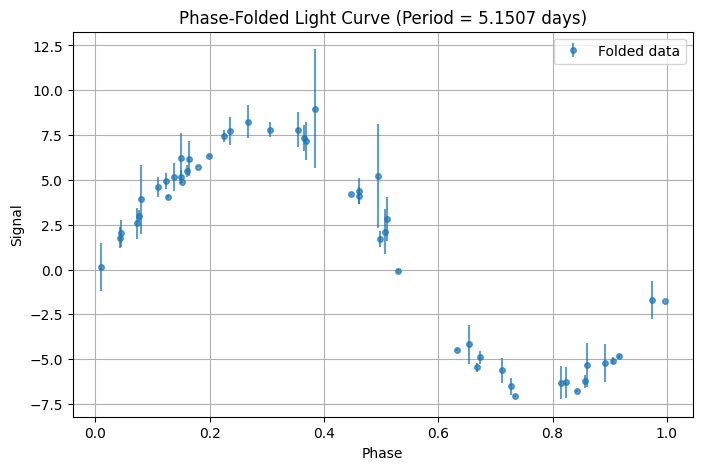

In [9]:
# best fit period
period = 1. / f_grid[np.argmax(psd_ls)]

phases = (x % period) / period # modulo for 'phase folded'

# plot the phase
plt.figure(figsize=(8, 5))
plt.errorbar(phases, y, yerr=dy, fmt='o', markersize=4, alpha=0.7, label='Folded data')
plt.xlabel('Phase')
plt.ylabel('Signal')
plt.title(f'Phase-Folded Light Curve (Period = {period:.4f} days)')
plt.legend()
plt.grid()
plt.show()


**Problem 1g**

`ls_periodogram` functions well, but the way we implemented it is slow. [`LombScargle`](http://docs.astropy.org/en/stable/timeseries/lombscargle.html) in `astropy.timeseries` is fast. Run it below to compare the results to `ls_periodogram`. There are many choices regarding the calculation of the periodogram, so [read the docs](http://docs.astropy.org/en/stable/api/astropy.timeseries.LombScargle.html#astropy.timeseries.LombScargle).

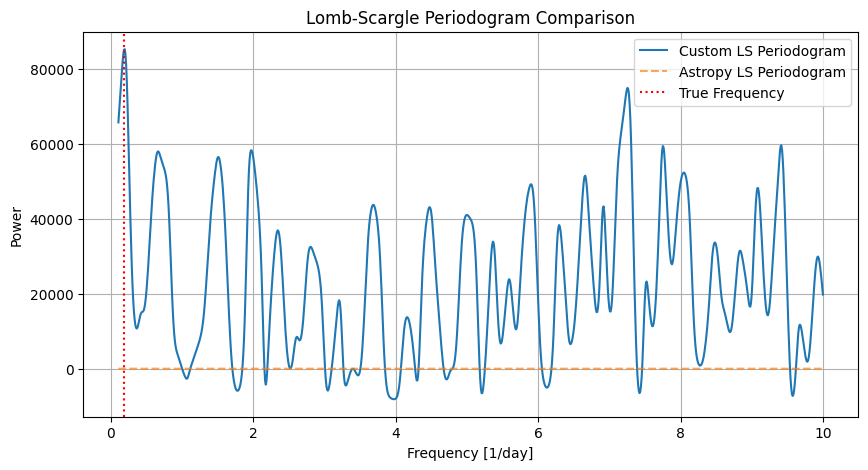

Best-fit period from Astropy LS: 5.1507 days


In [10]:
from astropy.timeseries import LombScargle

#
#  fast LS periodogram using astropy
frequency = f_grid
ls_astropy = LombScargle(x, y, dy)
power = ls_astropy.power(frequency)

# plot custom LS and astropy LS
plt.figure(figsize=(10, 5))
plt.plot(f_grid, psd_ls, label='Custom LS Periodogram')
plt.plot(frequency, power, linestyle='--', label='Astropy LS Periodogram', alpha=0.7)
plt.axvline(1/5.25, color='r', linestyle=':', label='True Frequency')
plt.xlabel("Frequency [1/day]")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram Comparison")
plt.legend()
plt.grid()
plt.show()

# compare best period from astropy
best_period_astropy = 1 / frequency[np.argmax(power)]
print(f"Best-fit period from Astropy LS: {best_period_astropy:.4f} days")


## Problem 2: Floating Mean Periodogram

A basic assumption that we preivously made is that the data are "centered" - in other words, our model explicitly assumes that the signal oscillates about a mean of 0.

For astronomical applications, this assumption can be harmful. Instead, it is useful to fit for the mean of the signal in addition to the periodic component (as is the default in `LombScargle`):

$$y(t;f) = y_0(f) + A_f \sin[2\pi f(t - \phi_f)].$$

To illustrate why this is important for astronomy, assume that any signal fainter than $-2$ in our simulated data cannot be detected. 

**Problem 2a**

Remove the observations from `x` and `y` where $y \le -2$ and calculate the periodogram both with and without fitting the mean (`fit_mean = False` in the call to `LombScargle`). Plot the periodograms. Do both methods recover the correct period? 

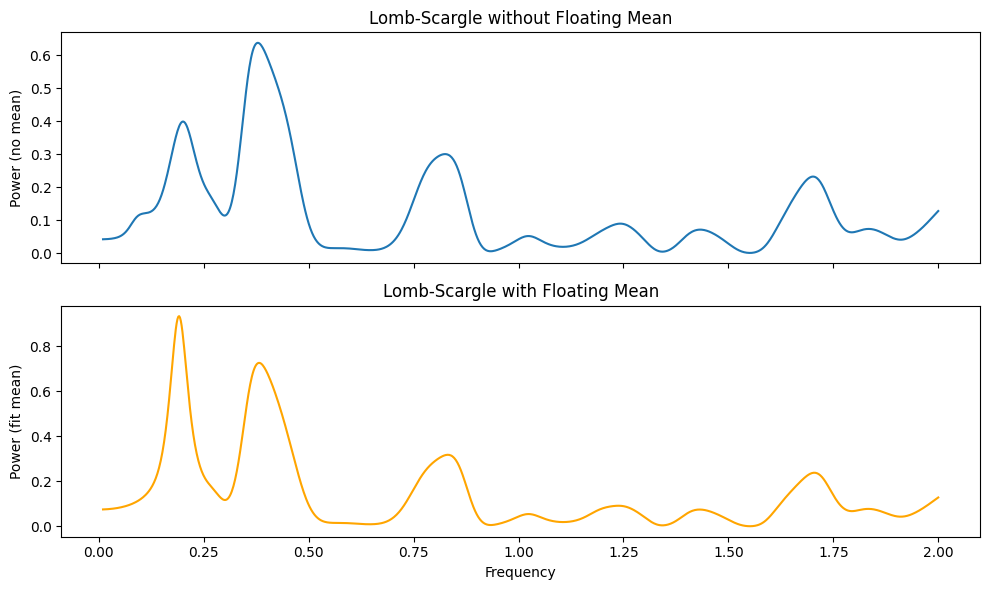

In [11]:
# remove observations
bright = y > -2
x_bright = x[bright]
y_bright = y[bright]

frequency = np.linspace(0.01, 2.0, 1000) 

# LS without fitting mean
ls_no_mean = LombScargle(x_bright, y_bright, fit_mean=False)
power_no_mean = ls_no_mean.power(frequency)

# LS with floating mean
ls_fit_mean = LombScargle(x_bright, y_bright, fit_mean=True)
power_fit_mean = ls_fit_mean.power(frequency)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

ax1.plot(frequency, power_no_mean)
ax1.set_ylabel("Power (no mean)")
ax1.set_title("Lomb-Scargle without Floating Mean")

ax2.plot(frequency, power_fit_mean, color='orange')
ax2.set_ylabel("Power (fit mean)")
ax2.set_title("Lomb-Scargle with Floating Mean")
ax2.set_xlabel("Frequency")

plt.tight_layout()
plt.show()

**Problem 2b**

Plot the reconstructed signals with and without the floating mean and compare them to the data.

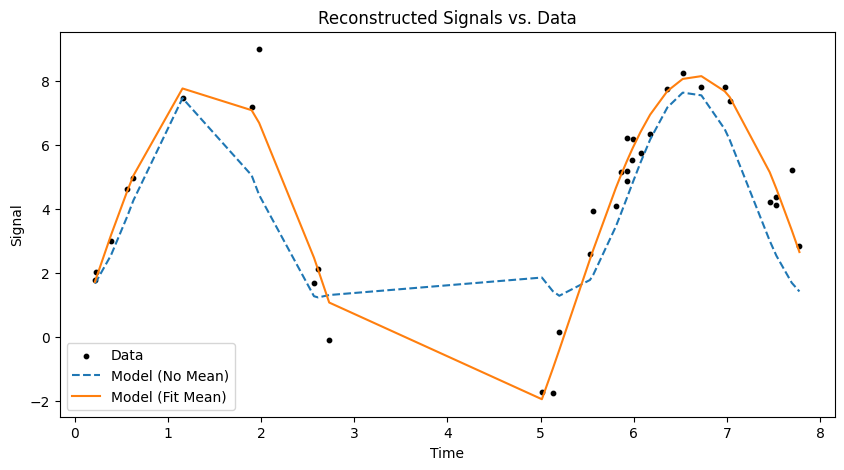

In [12]:
# best-fit frequencies (max power)
best_freq_no_mean = frequency[np.argmax(power_no_mean)]
best_freq_fit_mean = frequency[np.argmax(power_fit_mean)]

# reconstruct signals with best frequency
y_model_no_mean = ls_no_mean.model(x_bright, best_freq_no_mean)
y_model_fit_mean = ls_fit_mean.model(x_bright, best_freq_fit_mean)

# plot data and model
plt.figure(figsize=(10, 5))
plt.scatter(x_bright, y_bright, color='k', label='Data', s=10)
plt.plot(x_bright, y_model_no_mean, label='Model (No Mean)', linestyle='--')
plt.plot(x_bright, y_model_fit_mean, label='Model (Fit Mean)', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Reconstructed Signals vs. Data')
plt.legend()
plt.show()


## Problem 3: Window Functions

Let us simulate "realistic" observations for a 10 year telescope survey. We do this by assuming that a source is observed every 3 nights (the LSST cadence) within $\pm 4\,\mathrm{hr}$ of the same time, and that $\sim 30\%$ of the observations did not occur due to bad weather. We further assume that the source cannot be observed for 40% of the year because it is behind the sun.

**Problem 3a**

Simulate a periodic signal with 3 day cadence (and the observing conditions described above), a period = 220 days (typical for Miras), amplitude = 12.4, and variance of the noise = 1. Randomly generate uncertainties from a half-Gaussian with a standard deviation of 1. Plot the simulated light curve.

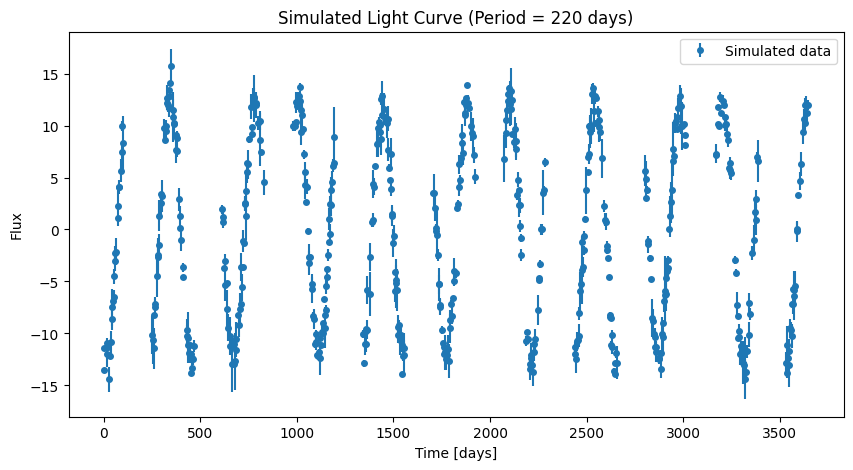

In [13]:
# set up simulated observations
years = 10
cadence_days = 3
total_days = years * 365.25
period = 220  # days
amplitude = 12.4
noise_std = 1

# cadence + noise
t_obs = np.arange(0, total_days, cadence_days)
t_obs += np.random.uniform(-0.167, 0.167, size=len(t_obs))

# remove when source cannot be observed (off-season)
observed_mask = []
for t in t_obs:
    day_of_year = t % 365.25
    if not (100 <= day_of_year <= 245):
        observed_mask.append(True)
    else:
        observed_mask.append(False)
t_obs = t_obs[np.array(observed_mask)]

# remove some data due to bad weather
mask_weather = np.random.rand(len(t_obs)) > 0.3  # keep 70%
t_obs = t_obs[mask_weather]

# simulate light curve
phi = np.random.uniform(0, 2*np.pi)  # random phase
true_signal = amplitude * np.sin(2 * np.pi * t_obs / period + phi)
noise = np.random.normal(0, noise_std, size=len(t_obs))
y = true_signal + noise

# simulate uncertainties with half-gaussian
y_unc = np.abs(np.random.normal(0, 1, size=len(t_obs)))

# plot
plt.figure(figsize=(10, 5))
plt.errorbar(t_obs, y, yerr=y_unc, fmt='o', markersize=4, label='Simulated data')
plt.xlabel('Time [days]')
plt.ylabel('Flux')
plt.title('Simulated Light Curve (Period = 220 days)')
plt.legend()
plt.show()


**Problem 3b**

Calculate and plot the periodogram for the window function (i.e., set `y = 1` in `LombScargle`) of the observations. Do you notice any significant power? What are the periods for this power and what does this tell us?

*Hint* - you may need to zoom in on the plot to see all the relevant features.

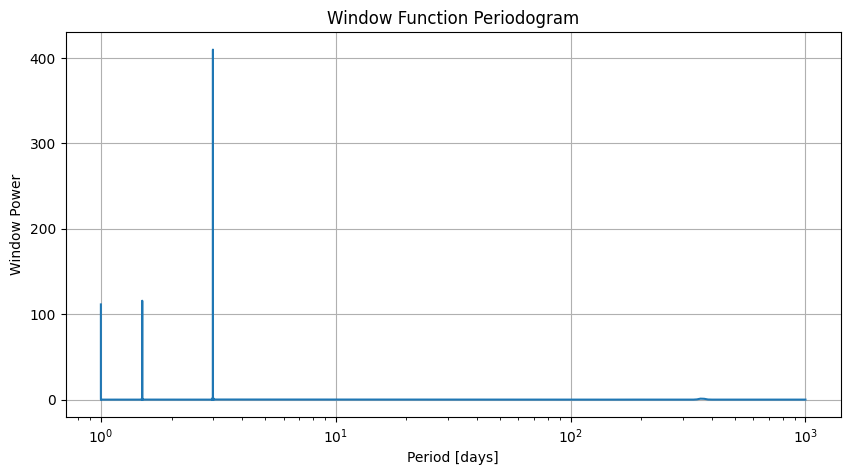

In [14]:
y_window = np.ones_like(t_obs)

# compute LS
ls = LombScargle(t_obs, y_window, fit_mean=True)
freq_window = np.linspace(0.001, 1.0, 10000)  # or wider range depending on resolution
power_window = ls.power(freq_window)

period_window = 1 / freq_window

plt.figure(figsize=(10, 5))
plt.plot(period_window, power_window)
plt.xlabel("Period [days]")
plt.ylabel("Window Power")
plt.title("Window Function Periodogram")
plt.xscale('log')
plt.grid()
plt.show()


*Do you notice any significant power? What are the periods for this power and what does this tell us?*

$\Rightarrow$ The small power at 1 year (almost 300 days) is due to the seasonal window of when the star is observable.\
The power at ~3 days is due to the survey cadence of 3 days.\
1 and 1.5 day peaks might also be due to the survey cadence.

**Problem 3c**

Calculate the periodogram for the data and compare it to the periodogram for the window function. Do you notice any significant power? What are the periods for this power and what does this tell us?

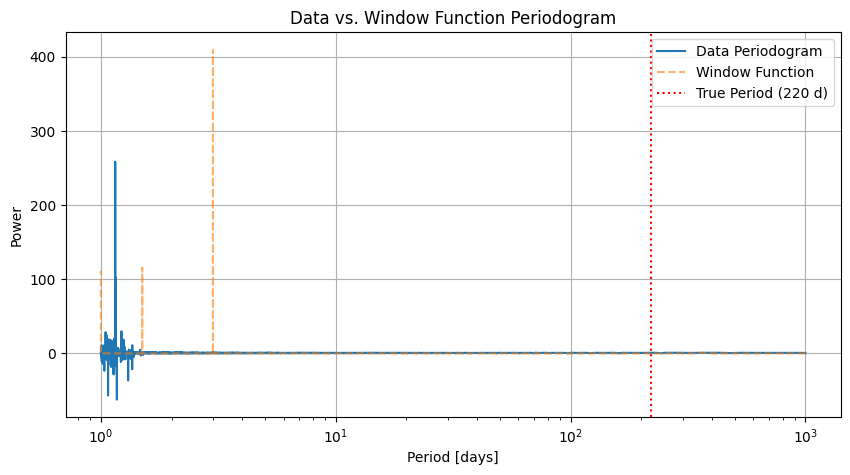

In [15]:
# LS of data
ls_data = LombScargle(t_obs, y, dy=y_unc, fit_mean=True)
frequency = np.linspace(0.001, 1.0, 10000)  # same as window function
power = ls_data.power(frequency)

# f to T
period = 1 / frequency
period_window = 1 / freq_window

# plot
plt.figure(figsize=(10, 5))
plt.plot(period, power, label='Data Periodogram')
plt.plot(period_window, power_window, label='Window Function', linestyle='--', alpha=0.6)
plt.axvline(220, color='red', linestyle=':', label='True Period (220 d)')
plt.xlabel('Period [days]')
plt.ylabel('Power')
plt.title('Data vs. Window Function Periodogram')
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()


*Calculate the periodogram for the data and compare it to the periodogram for the window function. Do you notice any significant power? What are the periods for this power and what does this tell us?*

$\Rightarrow$ 
I don't think this is how it's supposed to look, I'm so sorry!! 
There are peaks around 1 year, 3 days, and 1.5. These match the observing cadence and seasonal gaps, as expected. There's no period at 220 days marked even though that's what the true period is.